In [ ]:
''' 유전 알고리즘 멀티 프로세싱 구현 '''
''' 
    멀티 프로세싱으로 배정할 작업 목록
    - 개체군 적합도 평가(완료)
    -- 1. 개체군을 여러 개의 부분 집합으로 분할한다
    -- 2. worker 프로세스에게 부분 집합을 전달한 후, 그에 대한 적합도 평가를 수행하도록 한다
    -- 3. 적합도 평가가 완료되었다면 각 개체의 개체군 내 인덱스와 적합도 점수를 boss 프로세스에게 반환한다
    - 다음 개체군 생성(진행중)
    -- 1. 여러 개의 토너먼트를 추출 및 배치 단위로 분할한다
    -- 2. 토너먼트 배치를 worker 프로세스에게 전달한 후, 그로부터 자손 개체를 생성하도록 한다
    -- 3. 생성된 자손 개체를 boss 프로세스에게 반환한다
'''

In [1]:
''' 공유 텐서로 프로세스들의 동작을 동기화할 수 있음을 확인했다 '''
import torch
import torch.multiprocessing as mp
from lib.worker_testing4 import worker

# def testing(num, bucket_tensor, event_count):
#     done = False
#     while not done:
#         if event_count == 8: done = True
#     print(f"event_count : {event_count}")
    
#     for i in range(10):
#         bucket_tensor[num*10+i] = num*10+i
    
bucket_tensor = torch.zeros(80)
event_count = torch.tensor([0])
bucket_tensor.share_memory_()
event_count.share_memory_()

p_num = 8
p_pool = []

for i in range(p_num):
    p = mp.Process(target=worker, args=(i, bucket_tensor, event_count))
    p_pool.append(p)
    p.start()

for p in p_pool:
    p.join()
    p.terminate()
    p.close()

print(bucket_tensor)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79.])


Generation : 1
Generation : 2
Generation : 3
Generation : 4
Generation : 5
Generation : 6
Generation : 7
Generation : 8
Generation : 9
Generation : 10
Generation : 11
Generation : 12
Generation : 13
Generation : 14
Generation : 15
Generation : 16
Generation : 17
Generation : 18
Generation : 19
Generation : 20
Generation : 21
Generation : 22
Generation : 23
Generation : 24
Generation : 25
Generation : 26
Generation : 27
Generation : 28
Generation : 29
Generation : 30
running time : 3.2024 min


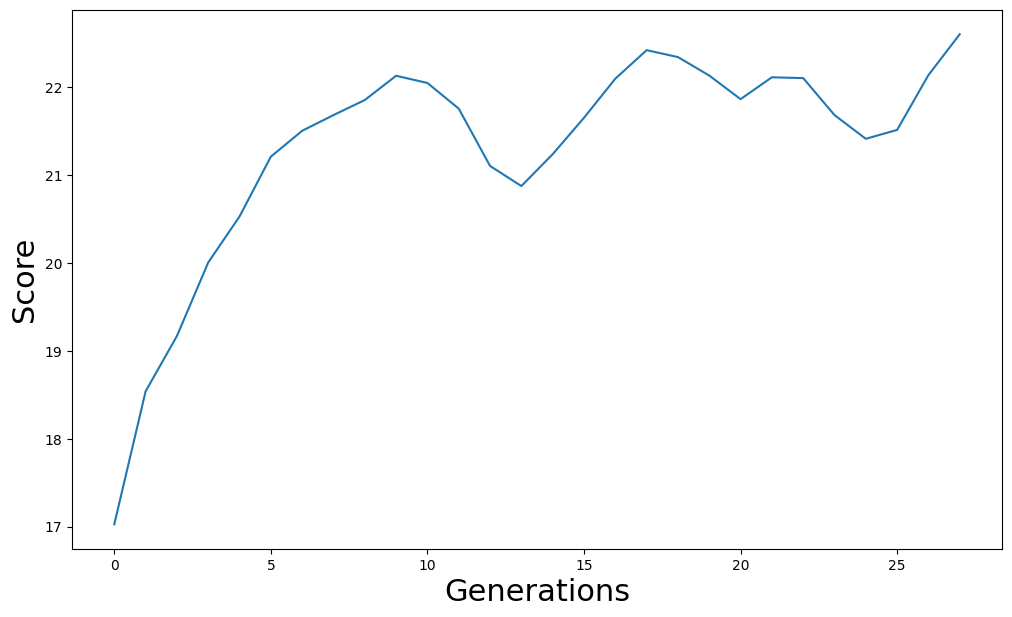

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time, os
import torch
import torch.multiprocessing as mp
from lib.eval_gene_worker import evaluate as e_worker
from lib.next_gen_worker import next_generation as ng_worker

''' boss 프로세스 '''
def spawn_population(pop_size, layers):
    tot_params_num = sum([np.prod(l) + l[1] for l in layers])
    params_set = torch.randn(pop_size, tot_params_num) / 2.0
    fitness_set = torch.zeros(pop_size, dtype=torch.int32)

    return params_set, fitness_set

def evaluate_management(p_num, layers, parmas_set, fitness_set):
    lp = params_set.shape[0] # 개체군 크기
    batch_range = np.arange(0, lp + 1, lp // p_num)
    batch_range[-1] = lp
    p_pool = []
    
    for i in range(p_num):
        p = mp.Process(target=e_worker, args=(batch_range[i:i+2], layers, params_set, fitness_set)) # 프로세스 생성
        p_pool.append(p)
        p.start() # worker 프로세스 실행
    
    for p in p_pool:
        p.join() # worker 프로세스가 작업을 완료할 때 까지 boss 프로세스가 간섭하지 못하도록 방지
        p.terminate() # worker 프로세스 종료
        p.close() # worker 프로세스 해제

def next_generation_management(p_num, tournament_size, mut_rate, params_set, fitness_set, event_count):
    lp = params_set.shape[0] # 개체군의 크기
    lt = lp // 2 # 한 개체군으로 다음 개체군을 만들기 위해 필요한 토너먼트의 개수
    tour_quota = np.arange(0, lt + 1, lt // p_num) # worker 프로세스에게 처리해야 할 토너먼트를 분할해주기 위한 범위 계산
    tour_quota[-1] = lt
    p_pool = []
    
    for i in range(p_num):
        # tour_quota[i:i+2]는 각 프로세스에게 처리해야 하는 토너먼트의 수량을 알려준다
        p = mp.Process(target=ng_worker, args=(tour_quota[i:i+2], tournament_size, mut_rate, params_set, fitness_set, event_count)) # 프로세스 생성
        p_pool.append(p)
        p.start() # worker 프로세스 실행
    
    for p in p_pool:
        p.join() # worker 프로세스가 작업을 완료할 때 까지 boss 프로세스가 간섭하지 못하도록 방지
        p.terminate() # worker 프로세스 종료
        p.close() # worker 프로세스 해제

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 것이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

pop_size = 500
layers = [(4, 25), (25, 10), (10, 2)]
params_set, fitness_set = spawn_population(pop_size, layers)
event_count = torch.tensor([0])
params_set.share_memory_()
fitness_set.share_memory_()
event_count.share_memory_()

p_num = 6
generation = 30
tournament_size = 0.2
mut_rate = 0.01
avg_fits = []

start = time.time()
for i in range(generation):
    print(f"Generation : {i+1}")
    evaluate_management(p_num, layers, params_set, fitness_set)
    avg_fits.append(fitness_set.sum(dtype=torch.float32) / fitness_set.shape[0])
    next_generation_management(p_num, tournament_size, mut_rate, params_set, fitness_set, event_count)
    event_count[0] = 0 # 인덱스를 사용하지 않으면 event_count에 저장된 텐서가 버려지고 정수 '0'이 저장된다
print(f"running time : {(time.time() - start) / 60:.4f} min")

''' 개체군 저장 '''
torch.save(params_set, os.path.join(os.getcwd(), "parameters", "params_set1.pt"))
torch.save(fitness_set, os.path.join(os.getcwd(), "parameters", "fitness_set1.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(avg_fits), 3))

In [4]:
fitness_set, params_set.shape[0]

(tensor([10, 11, 22, 10, 16, 30, 41, 11, 12, 18, 20, 29, 27, 29, 18, 10, 25, 17,
         41, 10,  9, 11, 15, 36, 15, 37, 31, 13, 12, 28, 13, 11, 16, 29, 23, 21,
         25, 47, 23, 18, 14, 18, 21, 32, 36, 14, 29, 25, 13, 10, 20, 13, 20, 14,
         11, 51, 14, 33, 16, 35, 12, 17, 20, 24, 19, 18, 17, 16, 20, 22, 15, 18,
         15, 11, 19, 24, 14, 19,  9, 10, 10, 18, 14, 19, 14, 25, 12, 19, 14, 17,
         23, 12, 22, 23, 84, 17, 25,  9, 20, 19, 25, 15, 42, 37, 16, 17, 15, 21,
         16, 13, 19, 11, 31, 34, 14, 24, 30, 19, 21, 25, 17, 21, 16, 25, 15, 20,
         13, 13, 26, 13, 13,  9, 15, 15, 30, 10, 18, 28, 63, 21, 39, 13, 16, 26,
         72,  8, 15, 13, 11, 43, 22, 16, 31, 12, 45, 16, 24, 16, 12, 22, 15, 15,
         22, 15, 23, 28, 20, 11, 13, 13, 23, 31, 18, 11, 39, 34, 28, 28, 11,  9,
         38, 28, 17, 27, 14, 42, 48, 26, 15, 29, 50, 37, 41, 11, 12, 28, 15, 14,
         11, 17, 19, 25,  8, 27, 20, 32, 14, 28, 18, 34, 39, 28, 38, 12, 21, 14,
         15, 25, 18, 17, 18,

In [ ]:
''' 개체 평가 worker 프로세스 '''
import gymnasium as gym
import numpy as np
import torch
from torch import nn

class LR_block(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.linear = nn.Linear(shape[0], shape[1])
        self.relu = nn.ReLU()
        # 유전 알고리즘의 학습은 역전파를 통한 학습과 다르므로 배치 정규화와 드롭아웃은 사용해봐야 의미가 없다

    def forward(self, x):
        output = self.relu(self.linear(x))

        return output

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.body = nn.Sequential(*[LR_block(shape) for shape in layers[:-1]])
        self.tail_top = nn.Linear(layers[-1][0], layers[-1][1])
        self.tail_bottom = nn.LogSoftmax(dim=0)

    def forward(self, x):
        output = self.body(x)
        output = self.tail_bottom(self.tail_top(output))

        return output

def unpack_params(params_vec, layers):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    start = 0
    for l in layers:
        division = np.prod(l)
        stop = start + division + l[1]
        layer_vec = params_vec[start:stop] # 각 계층의 매개변수 벡터를 추출한다
        unpacked_params.extend([layer_vec[0:division].reshape((l[1], l[0])), layer_vec[division:]]) # 각 계층에 해당하는 매개변수 벡터로부터 다시 가중치 벡터와 편향 벡터를 추출한다
        start = stop

    return unpacked_params

def reconstruct_state_dict(state_dict, parameters_set):
    for i, key in enumerate(state_dict):
        state_dict[key].copy_(parameters_set[i]) # 모델의 매개변수 텐서를 개체의 매개변수 텐서로 모두 덮어씌운다

    return state_dict

def evaluate(batch, layers, params_set, fitness_set):
    model = Model(layers)
    state_dict = model.state_dict()

    done = False
    score = 0
    env = gym.make("CartPole-v1")
    
    for idx in range(*batch):
        ''' 개체를 모델로 구현 '''
        model.load_state_dict(reconstruct_state_dict(state_dict, unpack_params(params_set[idx], layers)))

        ''' 개체 평가 '''
        cur_state = torch.from_numpy(env.reset()[0]).float()
        while not done: # done = True이면 반복문이 종료된다
            with torch.no_grad():
                logits = model(cur_state) # logits아닌 probs로 적혀있었던 것이 유전 알고리즘의 테스트에서 의도대로 작동하지 않았던 원인이었다
                                          # probs로 적어놨기 때문에 아래의 카테고리컬 분포 계산이 잘못 계산되었던 것이다
            action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
            next_state, _, done, _, _ = env.step(action.item())
            cur_state = torch.from_numpy(next_state).float()
            score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다
        
        fitness_set[idx] = score
        score = 0
        done = False

In [ ]:
''' 다음 개체군 생성 worker 프로세스 '''
import numpy as np
import torch
import random

def recombine(x1, x2):
    split_pt = np.random.randint(x1.shape[0]) # pt = point, 부모 개체의 교차점을 무작위로 추출한다
    # 자손 개체 생성
    child1 = torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다
    child2 = torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다

    return child1, child2

def mutate(x, rate=0.01):
    num_to_change = int(rate*x.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = random.sample(range(0, x.shape[0]), k=num_to_change) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                               # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    return x

def next_generation(tour_quota, mut_rate, tournament_size, params_set, fitness_set, event_count):
    lp = params_set.shape[0] # 개체군의 크기
    temp = []

    ''' 자손 개체 생성 '''
    print(f"tour_quota : {tour_quota}")
    for i in range(*tour_quota):
        # 토너먼트 생성 및 부모 개체 선정
        tournament = random.sample(range(0, lp), k=int(tournament_size*lp)) # 토너먼트에 참여할 개체를 추출한다
        tournament = np.array([[idx, fitness_set[idx]] for idx in tournament]) # 토너먼트를 재구성한다
        tournament = tournament[tournament[:, 1].argsort()] # 토너먼트에 속한 개체들을 적합도 점수를 기준으로 내림차순으로 정렬한 결과가 반환된다
        p1, p2 = params_set[tournament[-1][0]], params_set[tournament[-2][0]]

        # 자식 개체 생성
        offsprings = recombine(p1, p2)
        temp.extend([mutate(offsprings[0], mut_rate), mutate(offsprings[1], mut_rate)])

    ''' 현재 개체군에 생성된 자손 개체를 덮어씌우기 '''
    # 모든 worker 프로세스가 할당받은 토너먼트로부터 자손 개체의 생성을 완료할 때까지 대기(그렇지 않으면 다른 프로세스가 현세대 개체군으로 자손 개체를 생성할 수 없다)
    event_count += 1
    while True:
        if event_count == 8 : break
    print(f"event_count : {event_count}")
    
    # 1번 프로세스가 30개의 토너먼트(토너먼트 범위 [0:30])를 처리했다면 60개의 자손 개체가 생성된다
    # 그리고 이 60개의 자손 개체는 현세대 개체군의 인덱스 범위 [0:60]에 대입한다
    # 마찬가지의 논리로 2번 프로세스로부터(토너먼트 범위 [30:60]) 생성된 60개의 자손 개체는 현세대 개체군의 인덱스 범위 [60:120]에 대입한다
    # 위와 같은 과정을 모든 프로세스에서 수행하여 기존의 개체군을 새로운 개체군으로 갱신하도록 하는 것이 아래 인덱스 슬라이싱의 의미이다
    params_set[2*tour_quota[0]:2*tour_quota[1]] = torch.stack(temp, dim=0)[:]

Generation : 1
Generation : 2
Generation : 3
Generation : 4
Generation : 5
Generation : 6
Generation : 7
Generation : 8
Generation : 9
Generation : 10
Generation : 11
Generation : 12
Generation : 13
Generation : 14
Generation : 15
Generation : 16
Generation : 17
Generation : 18
Generation : 19
Generation : 20
Generation : 21
Generation : 22
Generation : 23
Generation : 24
Generation : 25
Generation : 26
Generation : 27
Generation : 28
Generation : 29
Generation : 30
running time : 1.7804 min


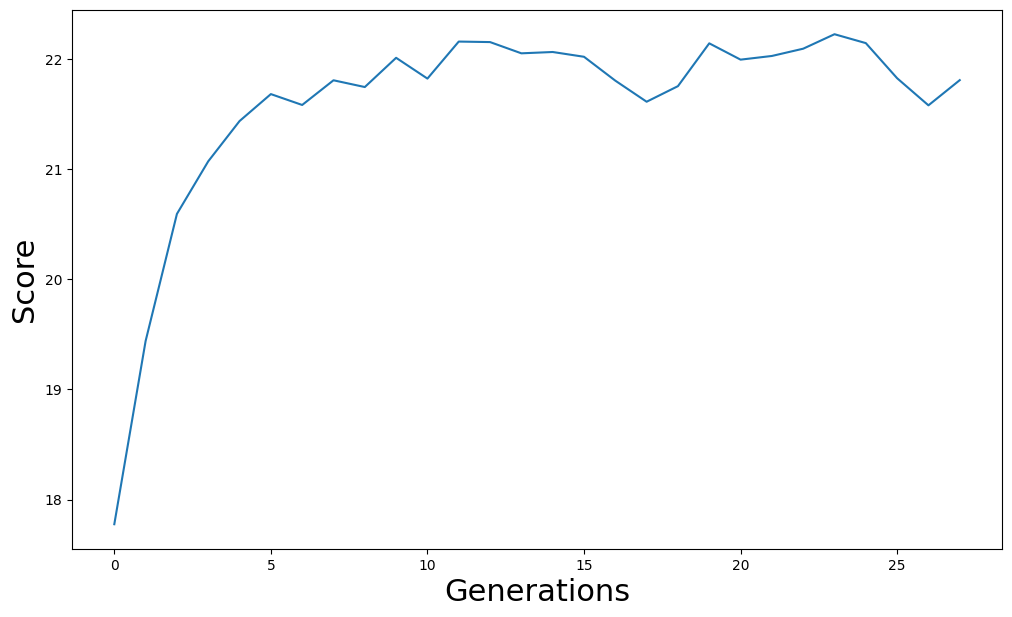

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time, os, random
import torch
import torch.multiprocessing as mp
from lib.eval_gene_worker import evaluate as e_worker

''' boss 프로세스 '''
def spawn_population(pop_size, layers):
    tot_params_num = sum([np.prod(l) + l[1] for l in layers])
    params_set = torch.randn(pop_size, tot_params_num) / 2.0
    fitnes_set = torch.zeros(pop_size, dtype=torch.int32)
    
    return params_set, fitness_set

def evaluate_management(p_num, layers, parmas_set, fitness_set):
    lp = params_set.shape[0] # 개체군 크기
    batch_range = np.arange(0, lp + 1, lp // p_num)
    batch_range[-1] = lp
    p_pool = []
    
    for i in range(p_num):
        p = mp.Process(target=e_worker, args=(batch_range[i:i+2], layers, params_set, fitness_set)) # 프로세스 생성
        p_pool.append(p)
        p.start() # worker 프로세스 실행
    
    for p in p_pool:
        p.join() # worker 프로세스가 작업을 완료할 때 까지 boss 프로세스가 간섭하지 못하도록 방지
        p.terminate() # worker 프로세스 종료
        p.close() # worker 프로세스 해제

def recombine(x1, x2):
    split_pt = np.random.randint(x1.shape[0]) # pt = point, 부모 개체의 교차점을 무작위로 추출한다
    # 자손 개체 생성
    child1 = torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다
    child2 = torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다

    return child1, child2

def mutate(x1, x2, rate=0.01):
    lx = x1.shape[0] # 개체의 크기
    num_to_change = int(rate*lx) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx1 = random.sample(range(0, lx), k=num_to_change) # 결정된 비율 만큼의 매개변수 인덱스를 중복없이 추출한다
    idx2 = random.sample(range(0, lx), k=num_to_change) # 결정된 비율 만큼의 매개변수 인덱스를 중복없이 추출한다
    x1[idx1] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                                 # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    x2[idx2] = torch.randn(num_to_change) / 10.0
    
    return x1, x2

def next_generation(mut_rate, tournament_size, params_set, fitness_set):
    lp = params_set.shape[0] # 개체군의 크기
    new_pop = []

    ''' 자손 개체 생성 '''
    while len(new_pop) != lp:
        # 토너먼트 생성 및 부모 개체 선정
        tr_idx = random.sample(range(0, lp), k=int(tournament_size*lp)) # 토너먼트에 참여할 개체를 추출한다
        tournament = np.array([[idx, fitness_set[idx]] for idx in tr_idx]) # 토너먼트를 재구성한다
        tournament = tournament[tournament[:, 1].argsort()] # 토너먼트에 속한 개체들을 적합도 점수를 기준으로 내림차순으로 정렬한 결과가 반환된다
        p1, p2 = params_set[tournament[-1][0]], params_set[tournament[-2][0]]

        # 자식 개체 생성
        new_pop.extend(mutate(*recombine(p1, p2), mut_rate))

    params_set[:] = torch.stack(new_pop, dim=0)[:] # 새로운 개체군 생성

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 것이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

pop_size = 500
layers = [(4, 25), (25, 10), (10, 2)]
params_set, fitness_set = spawn_population(pop_size, layers)
params_set.share_memory_()
fitness_set.share_memory_()

p_num = 6
generation = 30
tournament_size = 0.4
mut_rate = 0.01
avg_fits = []

start = time.time()
for i in range(generation):
    print(f"Generation : {i+1}")
    evaluate_management(p_num, layers, params_set, fitness_set)
    avg_fits.append(fitness_set.sum(dtype=torch.float32) / fitness_set.shape[0])
    next_generation(tournament_size, mut_rate, params_set, fitness_set)
print(f"running time : {(time.time() - start) / 60:.4f} min")

# print(f"max fitness of gene of final population : {max_gene(pop)}")

''' 개체군 저장 '''
torch.save(params_set, os.path.join(os.getcwd(), "parameters", "params_set2.pt"))
torch.save(fitness_set, os.path.join(os.getcwd(), "parameters", "fitness_set2.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(avg_fits), 3))

In [7]:
fitness_set

tensor([14, 41, 10, 17, 30, 16, 18, 13, 14, 21, 16, 15, 12, 38, 16, 12, 73, 33,
        14, 20, 13, 17, 35, 11, 15, 17, 10, 10, 42, 22, 27, 20, 26, 14, 27, 13,
        20, 18, 28, 23, 20, 19, 12, 37, 16, 46, 18, 17, 36, 12, 29, 40, 39, 10,
        26, 19, 15, 15, 17, 11, 16,  9, 15, 10, 50, 33, 19, 15, 35, 16, 31, 21,
        16, 19, 13,  9, 15, 15, 15, 15, 15, 17, 23, 10, 14, 31, 46, 28, 10, 41,
        40, 27, 54, 31, 10, 45, 17, 20, 17, 13, 12, 13, 31, 27, 12, 11, 39, 40,
        19, 33, 24, 21, 14, 19, 17, 22,  8, 31, 15, 16, 15, 15, 19, 24, 28, 11,
        19, 15, 20, 23, 25, 26, 24, 15, 34, 17, 31, 80, 22, 38, 20, 26, 50, 12,
        37, 11, 14, 25, 15, 14, 20, 23, 17, 14, 35, 12, 10, 17, 15, 27, 19, 10,
        72, 23, 22, 20, 23, 40, 18, 37, 45, 23, 19, 23, 25, 48, 16, 21, 19, 78,
        45, 21, 17, 10, 15, 15, 48, 26, 24, 19, 40, 33, 16, 14, 13, 27, 20, 11,
        18, 15, 13, 27, 19, 20, 11, 17, 21, 17, 29, 29, 17, 47, 47, 23, 15, 11,
        13, 17, 27, 40, 35, 38, 14, 32, 

In [ ]:
''' 개체 평가 worker 프로세스 '''
import gymnasium as gym
import numpy as np
import torch
from torch import nn

class LR_block(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.linear = nn.Linear(shape[0], shape[1])
        self.relu = nn.ReLU()
        # 유전 알고리즘의 학습은 역전파를 통한 학습과 다르므로 배치 정규화와 드롭아웃은 사용해봐야 의미가 없다

    def forward(self, x):
        output = self.relu(self.linear(x))

        return output

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.body = nn.Sequential(*[LR_block(shape) for shape in layers[:-1]])
        self.tail_top = nn.Linear(layers[-1][0], layers[-1][1])
        self.tail_bottom = nn.LogSoftmax(dim=0)

    def forward(self, x):
        output = self.body(x)
        output = self.tail_bottom(self.tail_top(output))

        return output

def unpack_params(params_vec, layers):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    start = 0
    for l in layers:
        division = np.prod(l)
        stop = start + division + l[1]
        layer_vec = params_vec[start:stop] # 각 계층의 매개변수 벡터를 추출한다
        unpacked_params.extend([layer_vec[0:division].reshape((l[1], l[0])), layer_vec[division:]]) # 각 계층에 해당하는 매개변수 벡터로부터 다시 가중치 벡터와 편향 벡터를 추출한다
        start = stop

    return unpacked_params

def reconstruct_state_dict(state_dict, parameters_set):
    for i, key in enumerate(state_dict):
        state_dict[key].copy_(parameters_set[i]) # 모델의 매개변수 텐서를 개체의 매개변수 텐서로 모두 덮어씌운다

    return state_dict

def evaluate(batch, layers, params_set, fitness_set):
    model = Model(layers)
    state_dict = model.state_dict()

    done = False
    score = 0
    env = gym.make("CartPole-v1")
    
    for idx in range(*batch):
        ''' 개체를 모델로 구현 '''
        model.load_state_dict(reconstruct_state_dict(state_dict, unpack_params(params_set[idx], layers)))

        ''' 개체 평가 '''
        cur_state = torch.from_numpy(env.reset()[0]).float()
        while not done: # done = True이면 반복문이 종료된다
            with torch.no_grad():
                logits = model(cur_state) # logits아닌 probs로 적혀있었던 것이 유전 알고리즘의 테스트에서 의도대로 작동하지 않았던 원인이었다
                                          # probs로 적어놨기 때문에 아래의 카테고리컬 분포 계산이 잘못 계산되었던 것이다
            action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
            next_state, _, done, _, _ = env.step(action.item())
            cur_state = torch.from_numpy(next_state).float()
            score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다
        
        fitness_set[idx] = score
        score = 0
        done = False